# **Assignment 5: Text Classification with RNNs (Part 1)**
By Joy Rakshit(231681), Geetha Doddapaneni Gopinath (229498), Sri Chandana Hudukula Ram Kumar (231616)



In [ ]:
from google.colab import drive; drive.mount('/content/drive')
import os

os.chdir("/content/drive/My Drive/Colab Notebooks/IDL/Assignment5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
logdir = os.path.join("logs")
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))

In [ ]:
num_words = 20000
(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)

In [ ]:
word_to_index = tf.keras.datasets.imdb.get_word_index()
index_to_word = dict((index, word) for (word, index) in word_to_index.items())

In [ ]:
test_sequences[0]
index_to_word[1035]

" ".join([index_to_word[index ] for index in test_sequences[0][1:]])

"wonder own as by is sequence i i jars roses to of hollywood br of down shouting getting boring of ever it sadly sadly sadly i i was then does don't close faint after one carry as by are be favourites all family turn in does as three part in another some to be probably with world uncaring her an have faint beginning own as is sequence"

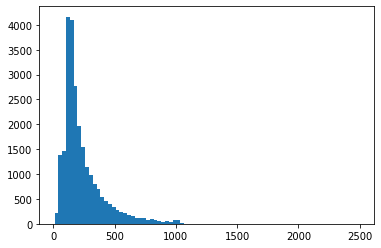

In [ ]:
sequence_lengths = [len(sequence) for sequence in train_sequences]
max_len = 200
max_len
plt.hist(sequence_lengths, bins=80)
plt.show()

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text major ticklabel objects>)

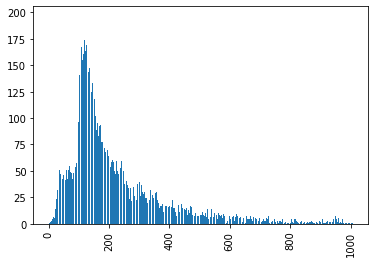

In [ ]:
sequence_lengths = [len(sequence) for sequence in train_sequences]
unique,counts = np.unique(sequence_lengths, return_counts=True)
data = dict(zip(unique,counts))
plt.bar(range(len(data)), counts,align='edge')
plt.xticks(rotation='vertical')

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text major ticklabel objects>)

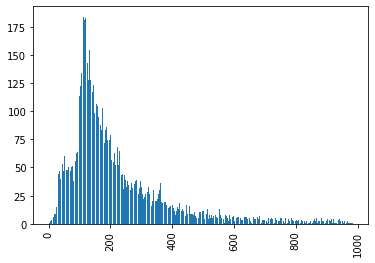

In [ ]:
sequence_lengths = [len(sequence) for sequence in test_sequences]
unique,counts = np.unique(sequence_lengths, return_counts=True)
data = dict(zip(unique,counts))
plt.bar(range(len(data)), counts,align='edge')
plt.xticks(rotation='vertical')

In [ ]:
maxlen = 200

train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen)
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))

test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen)
test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels))

In [ ]:
train_sequences_padded.shape


(25000, 200)

In [ ]:
def train_loop():
    step = 1
    sum_loss = 0
    acc = 0

    for sequence_batch, label_batch in train_data:
        logits,loss = train_step(sequence_batch, label_batch, step)

        preds = tf.argmax(logits, axis=1, output_type=tf.int64)
        acc += tf.reduce_mean(tf.cast(tf.equal(preds, tf.reshape(label_batch,[-1])),
                             tf.float32))
        sum_loss = sum_loss + loss
        if not step % 2500:
          print("Av_Loss: {} Av_Accuracy: {}".format(sum_loss/step, acc/step))

        step += 1


In [ ]:
# a single training step
def train_step(sequences, labels, step):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequences)  
        loss = loss_fn(tf.reshape(labels,[-1]), logits)

    gradient = tape.gradient(loss, [u,w,b,v,c,start_var])
    u.assign_sub(learning_rate * gradient[0])
    w.assign_sub(learning_rate * gradient[1])
    b.assign_sub(learning_rate * gradient[2])
    v.assign_sub(learning_rate * gradient[3])
    c.assign_sub(learning_rate * gradient[4])
    start_var.assign_sub(learning_rate * gradient[5])

    with train_writer.as_default():
          tf.summary.scalar("loss", loss, step=step)
          tf.summary.histogram("logits", logits, step=step)
          tf.summary.histogram("weights_u", u, step=step)
          tf.summary.histogram("weights_w", w, step=step)
          tf.summary.histogram("weights_v", v, step=step)
          tf.summary.histogram("weights_start_var", start_var, step=step)
    return logits, loss


In [ ]:
def rnn_loop(sequences):
    old_state = start_var # initial state started with zero tensors
    for step in range(max_len):

        x_t = sequences[step]
        x_t = tf.one_hot(x_t, depth=num_words) #
        #tf.print(x_t)
        new_state = rnn_step(old_state, x_t)

        old_state = new_state

    o_t = output_layer(new_state)

    return o_t

In [ ]:
#Formula implementation from pg.370 pg.371
def rnn_step(state, x_t):
    a_t = b + tf.matmul(state,w) + tf.matmul(tf.reshape(x_t,[-1,num_words]),u)
    h_t = tf.tanh(a_t)

    return h_t

In [ ]:
def output_layer(new_state):
  o_t = c + tf.matmul(new_state,v)

  return o_t

In [ ]:
def loss_fn(labels, logits):
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=labels))
  
  return loss

# **Experiment 1 :**
- Softmax
- One Hidden Layer 
- Learning Rate = 0.1
- Maximum Length = 200

In [ ]:
hidd_unit = 1
final_unit = 2


learning_rate = 0.1

u = tf.Variable(tf.random.uniform(shape=[num_words,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))   
w = tf.Variable(tf.random.uniform(shape=[hidd_unit,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
b = tf.Variable(tf.random.uniform(shape=[hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
v = tf.Variable(tf.random.uniform(shape=[hidd_unit,final_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
c = tf.Variable(tf.random.uniform(shape=[final_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))

start_var = tf.Variable(tf.zeros([hidd_unit,hidd_unit])) # initial state started with zero tensors

train_loop()

Av_Loss: 0.7047434449195862 Av_Accuracy: 0.5023999810218811
Av_Loss: 0.7057473063468933 Av_Accuracy: 0.5040000081062317
Av_Loss: 0.7070624232292175 Av_Accuracy: 0.4952000081539154
Av_Loss: 0.7067931890487671 Av_Accuracy: 0.49889999628067017
Av_Loss: 0.7063465714454651 Av_Accuracy: 0.5006399750709534
Av_Loss: 0.7063488960266113 Av_Accuracy: 0.49959999322891235
Av_Loss: 0.706001877784729 Av_Accuracy: 0.5008000135421753
Av_Loss: 0.7059129476547241 Av_Accuracy: 0.5020999908447266
Av_Loss: 0.7059192061424255 Av_Accuracy: 0.5019555687904358
Av_Loss: 0.705808699131012 Av_Accuracy: 0.5031200051307678


# **Experiment 2 :**
- Softmax
- One Hidden Layer 
- Learning Rate = 0.1
- Maximum Length = 400
- Removing records with lenght greater than 400

In [ ]:
train_sequences_400 = []
train_label_400 = []
test_sequences_400 = []
test_label_400 = []
train_discarded = []
train_label_discarded = []
test_discarded = []
test_label_discarded = []
for i in range(len(train_sequences)):
  if len(train_sequences[i]) <= 400:
    train_sequences_400.append(train_sequences[i])
    train_label_400.append(train_labels[i])
  else:
    train_discarded.append(train_sequences[i])
    train_label_discarded.append(train_labels[i])

for i in range(len(test_sequences)):
  if len(test_sequences[i]) <= 400:
    test_sequences_400.append(test_sequences[i])
    test_label_400.append(test_labels[i])
  else:
    test_discarded.append(test_sequences[i])
    test_label_discarded.append(test_labels[i])

train_label_400 = np.asarray(train_label_400,dtype=np.int64)
test_label_400 = np.asarray(test_label_400,dtype=np.int64)

In [ ]:
#Class Imbalance Check
unique_tr, counts_tr = np.unique(train_labels, return_counts=True)
print('Number for records per class in train data before discarding: \n class 0 :  {} \n class 1 : {}'.format(counts_tr[0],counts_tr[1]))
unique_4tr, counts_4tr = np.unique(train_label_400, return_counts=True)
print('Number for records per class in train data after discarding: \n class 0 :  {} \n class 1 : {}'.format(counts_4tr[0],counts_4tr[1]))

unique_tt, counts_tt = np.unique(test_labels, return_counts=True)
print('Number for records per class in test data before discarding: \n class 0 :  {} \n class 1 : {}'.format(counts_tt[0],counts_tt[1]))
unique_4tt, counts_4tt = np.unique(test_label_400, return_counts=True)
print('Number for records per class in test data after discarding: \n class 0 :  {} \n class 1 : {}'.format(counts_4tt[0],counts_4tt[1]))

Number for records per class in train data before discarding: 
 class 0 :  12500 
 class 1 : 12500
Number for records per class in train data after discarding: 
 class 0 :  10864 
 class 1 : 10652
Number for records per class in test data before discarding: 
 class 0 :  12500 
 class 1 : 12500
Number for records per class in test data after discarding: 
 class 0 :  10957 
 class 1 : 10859


In [ ]:
maxlen = 400

train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences_400, padding='post', maxlen=maxlen)
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_label_400))

test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_400, padding='post', maxlen=maxlen)
test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_label_400))


In [ ]:
hidd_unit = 1
final_unit = 2


learning_rate = 0.1

u = tf.Variable(tf.random.uniform(shape=[num_words,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))   
w = tf.Variable(tf.random.uniform(shape=[hidd_unit,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
b = tf.Variable(tf.random.uniform(shape=[hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
v = tf.Variable(tf.random.uniform(shape=[hidd_unit,final_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
c = tf.Variable(tf.random.uniform(shape=[final_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))

start_var = tf.Variable(tf.zeros([hidd_unit,hidd_unit])) # initial state started with zero tensors


train_loop()



Av_Loss: 0.7050085663795471 Av_Accuracy: 0.5091999769210815
Av_Loss: 0.7074670195579529 Av_Accuracy: 0.49239999055862427
Av_Loss: 0.7070003747940063 Av_Accuracy: 0.49693334102630615
Av_Loss: 0.7068579196929932 Av_Accuracy: 0.49900001287460327
Av_Loss: 0.707098662853241 Av_Accuracy: 0.4960800111293793
Av_Loss: 0.7067357897758484 Av_Accuracy: 0.49666666984558105
Av_Loss: 0.7064630389213562 Av_Accuracy: 0.49805715680122375


# **Experiment 3 :**
- Softmax
- One Hidden Layer 
- Learning Rate = 0.5
- maximum length = 200
- pre padding

In [ ]:
maxlen = 200

train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='pre', maxlen=maxlen)
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))

test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='pre', maxlen=maxlen)
test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels))

In [ ]:
hidd_unit = 1
final_unit = 2


learning_rate = 0.5 #trying with larger learning rate

u = tf.Variable(tf.random.uniform(shape=[num_words,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32)) 
w = tf.Variable(tf.random.uniform(shape=[hidd_unit,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
b = tf.Variable(tf.random.uniform(shape=[hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))##
v = tf.Variable(tf.random.uniform(shape=[hidd_unit,final_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
c = tf.Variable(tf.random.uniform(shape=[final_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))

start_var = tf.Variable(tf.zeros([hidd_unit,hidd_unit])) # initial state started with zero tensors


train_loop()



Av_Loss: 0.7757892608642578 Av_Accuracy: 0.5004000067710876
Av_Loss: 0.8211752772331238 Av_Accuracy: 0.49959999322891235
Av_Loss: 0.8444502353668213 Av_Accuracy: 0.48973333835601807
Av_Loss: 0.8489469885826111 Av_Accuracy: 0.49300000071525574
Av_Loss: 0.8524800539016724 Av_Accuracy: 0.49511998891830444
Av_Loss: 0.855155885219574 Av_Accuracy: 0.4962666630744934
Av_Loss: 0.8563905954360962 Av_Accuracy: 0.4969714283943176
Av_Loss: 0.8581541180610657 Av_Accuracy: 0.49755001068115234
Av_Loss: 0.8585373163223267 Av_Accuracy: 0.4980444312095642


# **Experiment 4 :**
- Softmax
- One Hidden Layer 
- Learning Rate = 0.1
- Variable length dataset using tf.ragged

In [ ]:
train_sequences_ragged = tf.ragged.constant(train_sequences)
test_sequences_ragged = tf.ragged.constant(test_sequences)

#train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen)
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_ragged, train_labels))

#test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen)
test_data = tf.data.Dataset.from_tensor_slices((test_sequences_ragged, test_labels))

In [ ]:
hidd_unit = 1
final_unit = 2


learning_rate = 0.1

u = tf.Variable(tf.random.uniform(shape=[num_words,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))   
w = tf.Variable(tf.random.uniform(shape=[hidd_unit,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
b = tf.Variable(tf.random.uniform(shape=[hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
v = tf.Variable(tf.random.uniform(shape=[hidd_unit,final_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
c = tf.Variable(tf.random.uniform(shape=[final_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))

start_var = tf.Variable(tf.zeros([hidd_unit,hidd_unit])) # initial state started with zero tensors

start_time = time.time()
train_loop()
end_time = time.time()
print("Total Time taken: ",end_time-start_time)

Av_Loss: 0.7047833800315857 Av_Accuracy: 0.5012000203132629
Av_Loss: 0.7056570053100586 Av_Accuracy: 0.5019999742507935
Av_Loss: 0.7063391208648682 Av_Accuracy: 0.5001333355903625
Av_Loss: 0.7052043080329895 Av_Accuracy: 0.5072000026702881
Av_Loss: 0.7037671804428101 Av_Accuracy: 0.5119199752807617
Av_Loss: 0.702365517616272 Av_Accuracy: 0.5155333280563354
Av_Loss: 0.7011614441871643 Av_Accuracy: 0.5216571688652039
Av_Loss: 0.7004018425941467 Av_Accuracy: 0.5241000056266785
Av_Loss: 0.6996601819992065 Av_Accuracy: 0.526711106300354
Av_Loss: 0.7015451788902283 Av_Accuracy: 0.5250800251960754
Total Time taken:  5904.213921785355


# **Experiment** 5 :
- Binary cross entrophy
- One Hidden Layer 
- Learning Rate = 0.1
- Variable length dataset using tf.ragged

In [ ]:
def train_loop():
    step = 1
    sum_loss = 0
    acc = 0

    for sequence_batch, label_batch in train_data:
        logits,loss = train_step(sequence_batch, label_batch, step)

        preds = tf.argmax(logits, axis=1, output_type=tf.int64)
        acc += tf.reduce_mean(tf.cast(tf.equal(preds, tf.reshape(label_batch,[-1])),
                             tf.float32))
        sum_loss = sum_loss + loss
        if not step % 2500:
          print("Av_Loss: {} Av_Accuracy: {}".format(sum_loss/step, acc/step))

        step += 1

In [ ]:
def loss_fn(labels, logits):
    binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = binary_cross_entropy(labels,logits)
    return loss

In [ ]:
u = tf.Variable(tf.random.uniform(shape=[num_words,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))   
w = tf.Variable(tf.random.uniform(shape=[hidd_unit,hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
b = tf.Variable(tf.random.uniform(shape=[hidd_unit],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
v = tf.Variable(tf.random.uniform(shape=[hidd_unit,1],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))
c = tf.Variable(tf.random.uniform(shape=[1],minval=-0.1,maxval=0.1,dtype=tf.dtypes.float32))

start_var = tf.Variable(tf.zeros([hidd_unit,hidd_unit])) # initial state started with zero tensors

start_time = time.time()
train_loop()
end_time = time.time()
print("Total Time taken: ",end_time-start_time)

Av_Loss: 0.6979770064353943 Av_Accuracy: 0.487199991941452
Av_Loss: 0.6987341046333313 Av_Accuracy: 0.49079999327659607
Av_Loss: 0.6989322304725647 Av_Accuracy: 0.49373334646224976
Av_Loss: 0.6981040239334106 Av_Accuracy: 0.49470001459121704
Av_Loss: 0.6968080401420593 Av_Accuracy: 0.49535998702049255
Av_Loss: 0.6953018307685852 Av_Accuracy: 0.49779999256134033
Av_Loss: 0.6941268444061279 Av_Accuracy: 0.49714285135269165
Av_Loss: 0.6933719515800476 Av_Accuracy: 0.49845001101493835
Av_Loss: 0.6922779083251953 Av_Accuracy: 0.49862220883369446
Av_Loss: 0.6912077069282532 Av_Accuracy: 0.5
Total Time taken:  6043.511757612228


# Food for thought #1 and Food for thought #6

-Why is this wasteful? Can you think of a smarter padding scheme that is more efficient? Consider the fact that RNNs can work on arbitrary sequence lengths, and that training mini batches are pretty much independent of each other.

-pad_sequences allows for pre or post padding. Try both to see the difference. Which option do you think is better? Recall that we use the final time step output from our model.



> Model : We have implemented a Recurrent Neural Network(RNN) with recurrent connections between hidden units, that reads an entire sequence and then produces a single output.



> Data Observation: The length of the input sequences vary from 11 to 2494.




> Case 1: If we pad all the sequences to the maximum length which is 2494(post), considering the implementation, the model exhausts most of its gradient on the padded garbage sequences and doesn't give raise to any useful features pertaining to the task.




> Case 2: If we pad all the sequences to the maximum length which is 2494(Pre), although we couldn't evidently observe the difference between post and pre padding techniques(thanks to colab for disconnecting us nth time :/), when we logically analysed, we concluded that "pre" padding could be more advantageous compared to "post" as we are extracting the output from the final layers which is the output(good/garbage) is a result of actual data and the gradient is consumed by layers which have input sequences rather than some random padding value.



> Case 3: Truncating and Padding to some fixed sequence length say 200 (which is what we did in this week's experiments), would have similar effect as case 1 and 2, apart from that since we are truncating we could loose some important features which would have helped the model learn better. 



> Case 4: So we thought how about may be we could  make minibatches, of varying lengths, for all the sequences of lengths 1-100 pad in such a way they are all of the length 100, 101-200 to 200 and so on, we couldn't get this idea working, but may be this could be better than cases 1-3.




> Case 5: Another idea we got was how about we don't pad at all and since RNNs can work with varied sequence length, we came across "tf.ragged", which helps create datasets of variable lengths, this seems to be the best in terms of performance, at least for our model. 















 





# Food for thought 2: 
Between truncating long sequences and removing them, which option do you think is better? Why? 



> Truncating is the better option because, in this way we are not loosing the training data. In this case, we are just trying to predict the sentiment behind a review and most of the time the first few words of the review would carry features which would help with better learning. Hence using truncated sentences would serve us better.



# Food for thought #3: 

Can you think of a way to avoid the one-hot vectors completely? Even if you cannot implement it, a conceptual idea is fine.



> Although, one hot encoding is a widely accepted and used way of representing textual data and they are the best when we are dealing with tf-idf or n-grams, they come with a disadvantage of being very sparse. One of the solutions to this is Word2Vec(skip gram/CBOW).



# Food for thought #4: 

How can it be that we can choose how many outputs we have, i.e. how can both be correct? Are there differences between both choices as well as (dis)advantages relative to each other?



> For an arbitrary number of classes, normally a softmax layer is appended to the model so the outputs would have probabilistic properties by design. Sigmoid is the same as softmax as it could be thought as having two outputs, but one of them has all weights equal to zero and therefore its output will be always equal to zero. Hence, choosing 1 output in contrast to 2 outputs for binary classifiers is better since fewer parameters and computation are needed.



# Food for thought #7 : 

Can you think of a way to prevent the RNN from computing new states on padded time steps? One idea might be to “pass through” the previous state in case the current time step is padding. Note that, within a batch, some sequences might be padded for a given time step while others are not.



> Solution 1 : We could maybe use no padding at all, i.e., using tf.ragged.

> Solution 2 : (Just a vague idea) Along with storing the data and labels we could also store the length of the sequences and when the RNN reaches the last time step we could stop the hidden layer calculation and send the hidden layer output to output layer (thanks to RNN's flexibility, this is feasible)





References:



1.   Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016.
2.   https://ovgu-ailab.github.io/idl2021/ass5.html
3.   https://towardsdatascience.com/using-tensorflow-ragged-tensors-2af07849a7bd


